In [1]:
%matplotlib TkAgg

import matplotlib.pyplot as plt
import mne
import numpy as np
import scipy
from scipy.signal import butter, sosfilt, freqs
import sys
import lzma

In [38]:
def standardizeMatrix(matrixOriginal):
    matrix = np.copy(matrixOriginal)

    floatType = type(matrix[0,0])
    rows, cols = matrix.shape
    matrix = matrix.astype(np.float64)
    
    for i in range(rows):
        mu = np.mean(matrix[i,:])
        sigma = np.std(matrix[i,:])
        matrix[i,:] = (matrix[i,:] - mu) / sigma
    return matrix.astype(floatType)


def elimPeaks(filteredMatrix, sigmaThreshold, sampleHalfWidthElim, sampleMinGap):

    standardizedMatrix = standardizeMatrix(filteredMatrix)
    peakList = []
    nChannel, nSample = standardizedMatrix.shape
    
    for i in range(nChannel):
        for j in range(nSample):
            if np.abs(standardizedMatrix[i,j]) > sigmaThreshold:
                peakList.append(j)
    peakList = list(set(peakList))
    peakList.sort()

    intervalList = [(thisPeak - sampleHalfWidthElim, thisPeak + sampleHalfWidthElim) for thisPeak in peakList]

    mergedIntervalList = [intervalList[0]]
    for i in range(1, len(intervalList)):
        currentInterval = mergedIntervalList[-1]
        nextInterval = intervalList[i]
        if currentInterval[1] + sampleMinGap >= nextInterval[0]:
            mergedIntervalList[-1] = (currentInterval[0], nextInterval[1])
        else:
            mergedIntervalList.append(nextInterval)
        
    startIndex = 0
    matrixList = []
    for i in range(0, len(mergedIntervalList)):
        intervalStart, intervalEnd = mergedIntervalList[i]
        thisMatrix = np.copy(filteredMatrix[:, startIndex:intervalStart])
        matrixList.append(thisMatrix)
        startIndex = intervalEnd + 1

    return matrixList, mergedIntervalList

In [3]:
filename = 'SVD001.edf'
raw = mne.io.read_raw_edf('G:/My Drive/NeuroResearch/Data/eegCompress/ExampleLTMFiles/' + filename)

Extracting EDF parameters from G:\My Drive\NeuroResearch\Data\eegCompress\ExampleLTMFiles\SVD001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\jetti\AppData\Local\Temp\ipykernel_23172\626497673.py:2: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf('G:/My Drive/NeuroResearch/Data/eegCompress/ExampleLTMFiles/' + filename)


In [4]:
print(raw)
print(raw.info)

<RawEDF | SVD001.edf, 46 x 1276416 (4986.0 s), ~39 KiB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, F7, T7, P7, O1, F3, C3, P3, A1, Fz, Cz, Fp2, F8, T8, P8, ...
 chs: 46 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2001-01-01 04:46:55 UTC
 nchan: 46
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: SVD001>
>


In [5]:
goodChannels = ['Fp1','F3','C3','P3','O1','Fp2','F4','C4','P4','O2','F7','T7','P7','F8','T8','P8','Fz','Cz','Pz']

# Temp

In [55]:
sigmaThreshold = 8
sampleHalfWidthElim = 128
sampleMinGap = 256

chanList = mne.pick_channels(raw.info['ch_names'], goodChannels)
temp = raw.get_data()[chanList]
tempList, intervalList = elimPeaks(temp, sigmaThreshold, sampleHalfWidthElim, sampleMinGap)

#tempCat = np.concatenate(tempList, 1)

In [102]:
chan[0]

np.float64(2.1666178377966e-05)

In [135]:
blockIndex = 7
mySize = 0
numChannel = 19
numBytesInData = 8

block = tempList[blockIndex]
reconstructBlock = np.zeros_like(block)

for chanIndex in range(numChannel):
    chan = block[chanIndex,:]

    chanDiff = (np.diff(chan) * (10**6)).astype(np.int8)

    myCompress = lzma.compress(chanDiff, preset = 9)
    #myDecompress = lzma.decompress(myCompress)
    #myDecompress = [i if i < 128 else (i - 256) for i in myDecompress]

    first = (chan[0] * (10**6)).astype(np.int8)
    chanReconstruct = np.insert(np.cumsum(chanDiff) + first, 0, first)
    reconstructBlock[chanIndex,:] = np.copy(chanReconstruct)

    mySize = mySize + sys.getsizeof(myCompress)
    
# calculate compression via bytes
print((len(chan) * numBytesInData * numChannel)/ mySize)

29.004394469014233


In [151]:
np.max(np.diff(block)) * 10**6, np.min(np.diff(block)) * 10**6

(np.float64(170.13931486991686), np.float64(-227.02964827954523))

In [152]:
np.array([227]).astype(np.int8)

array([-29], dtype=int8)

In [144]:
np.max(np.cumsum(chanDiff))

np.int64(892)

In [122]:
tempBlock = (block * (10**6)).astype(np.int8)
tempBlock.shape

(19, 1100367)

In [137]:
tempBlock[0,0:10]

array([21, 24, 25, 22, 22, 26, 28, 24, 21, 25], dtype=int8)

In [138]:
reconstructBlock[0,0:10]

array([21., 23., 23., 21., 21., 24., 26., 23., 20., 23.])

In [139]:
np.max(np.abs(tempBlock - reconstructBlock))

np.float64(3790.0)

In [141]:
np.max(np.abs(reconstructBlock)), np.max(np.abs(tempBlock))

(np.float64(3860.0), np.int8(127))

Creating RawArray with float64 data, n_channels=19, n_times=1100367
    Range : 0 ... 1100366 =      0.000 ...  4298.305 secs
Ready.


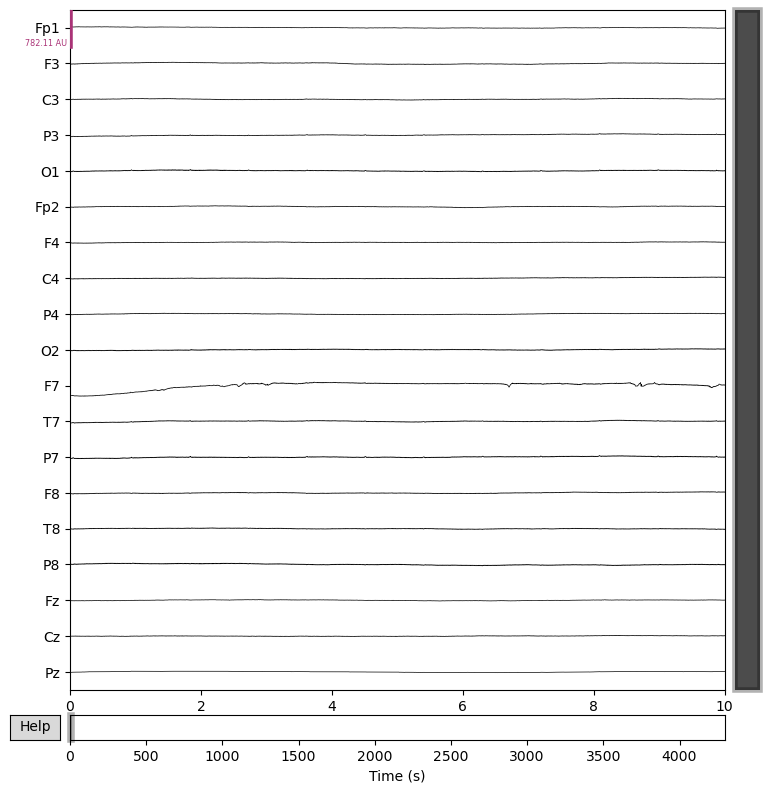

In [136]:
tempMatrix = reconstructBlock

info = mne.create_info(goodChannels, 256)
tempRaw = mne.io.RawArray(tempMatrix, info)
tempRaw.plot()

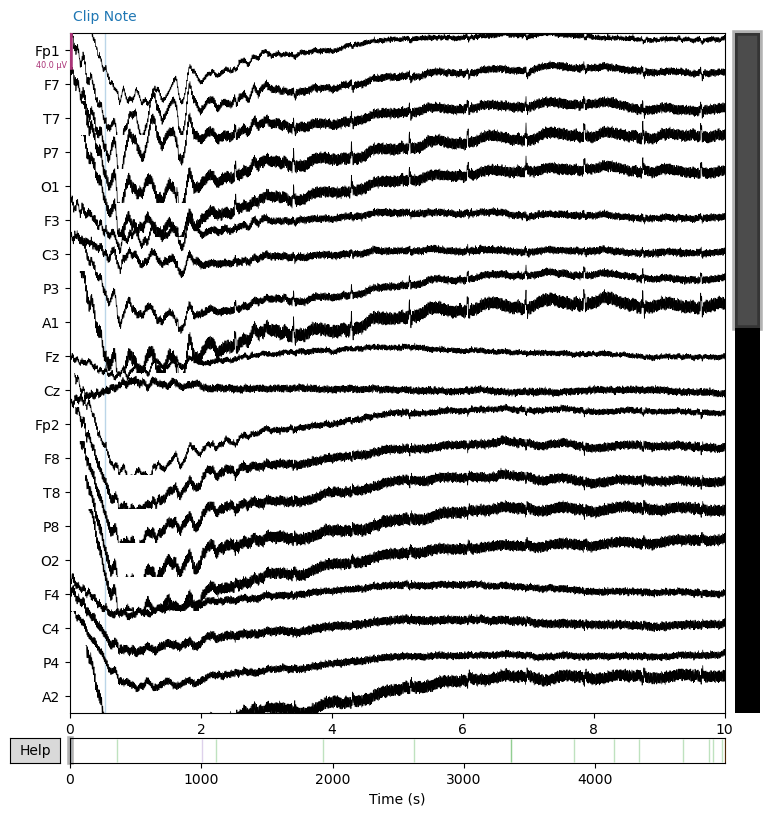

In [116]:
raw.plot()

In [ ]:
block = 7
chanIndex = 0

chan = tempList[block][chanIndex,:]

chanDiff = np.diff((chan) * (10**6)).astype(np.int8)
myCompress = lzma.compress(chanDiff, preset = 9)

print(sys.getsizeof(list(chan))/ sys.getsizeof(myCompress))

# Temp End

In [6]:
lowPass = 40
sigmaThreshold = 8
sampleHalfWidthElim = 128
sampleMinGap = 256

chanList = mne.pick_channels(raw.info['ch_names'], goodChannels)

data = raw.get_data()[chanList]
nChannel, nSample = data.shape

sos = butter(30, [1,lowPass], 'bandpass', fs=256, output='sos')
dataFiltered = sosfilt(sos, data, -1)

#dataStandardized = standardizeMatrix(dataFiltered)
dataList, intervalList = elimPeaks(dataFiltered, sigmaThreshold, sampleHalfWidthElim, sampleMinGap)

In [7]:
plt.figure()
plt.plot(dataStandardized[0,:])

In [8]:
catData = np.concatenate(dataList,1)

plt.figure()
plt.plot(catData[0,:])

In [15]:
np.savez_compressed('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/' + 'processed' + filename[0:-4], *dataList)

# Scratch

In [ ]:
np.save('G:/My Drive/NeuroResearch/Data/eegCompress/processedData/' + filename[0:-4], data)